## 1. Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [1]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [2]:
## TODO: Define the Net in models.py

import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from models import Net

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout2d(p=0.1, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop2): Dropout2d(p=0.2, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop3): Dropout2d(p=0.3, inplace=False)
  (conv4): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop4): Dropout2d(p=0.4, inplace=False)
  (fc1): Linear(in_features=43264, out_features=256, bias=True)
  (drop5): Dropout2d(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (drop6): Dropout2d(p=0.6, inplace=False)
  (fc3): Linear(in_fe

## 2. Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [3]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale(250), RandomCrop(224), Normalize(), ToTensor()])

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [4]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv',
                                             root_dir='data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462


E:\Coursera\CVND\prj1\P1_Facial_Keypoints\data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [5]:
# load training data in batches
batch_size = 10

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)


## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [6]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='data/test_frames_keypoints.csv',
                                             root_dir='data/test/',
                                             transform=data_transform)

In [7]:
# load test data in batches
batch_size = 10

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

## 3. Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Make sure the image is a FloatTensor, which the model expects.
3. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [8]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [9]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

C:\Users\kliu14\Anaconda2\envs\vision\lib\site-packages\torch\nn\functional.py:1339: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [10]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

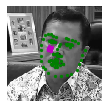

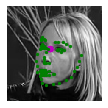

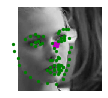

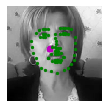

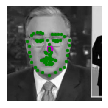

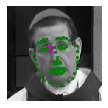

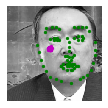

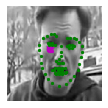

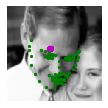

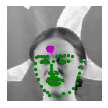

In [11]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

In [12]:
gt_pts[0]

tensor([[-0.3235, -0.4344],
        [-0.3929, -0.1746],
        [-0.3929,  0.0853],
        [-0.3929,  0.3278],
        [-0.3929,  0.5877],
        [-0.3235,  0.8476],
        [-0.2019,  0.9688],
        [-0.0804,  1.1767],
        [ 0.2494,  1.2980],
        [ 0.5619,  1.3153],
        [ 0.8224,  1.2460],
        [ 1.0133,  1.1940],
        [ 1.2737,  1.0035],
        [ 1.3953,  0.7436],
        [ 1.4647,  0.5530],
        [ 1.5342,  0.2932],
        [ 1.6557,  0.0506],
        [-0.2019, -0.6250],
        [-0.0804, -0.6770],
        [ 0.0585, -0.6770],
        [ 0.1800, -0.6077],
        [ 0.3189, -0.5557],
        [ 0.7529, -0.4864],
        [ 0.8918, -0.4691],
        [ 1.0828, -0.4171],
        [ 1.2043, -0.3478],
        [ 1.3432, -0.2785],
        [ 0.5099, -0.2266],
        [ 0.4404, -0.1053],
        [ 0.3710,  0.0333],
        [ 0.3710,  0.2239],
        [ 0.1800,  0.2759],
        [ 0.2494,  0.2759],
        [ 0.3710,  0.3452],
        [ 0.4404,  0.3452],
        [ 0.5619,  0

In [13]:
np_test_rst = test_outputs[0].data.numpy()
print(np_test_rst.max())
print(np_test_rst.min())


0.09508992
-0.116029374


## 4. Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [14]:
## TODO: Define the loss and optimization
import torch.optim as optim

criterion = nn.MSELoss()

optimizer = optim.Adam(params=net.parameters())


## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [28]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()
    loss_list = []

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            # to convert loss into a scalar and add it to the running_loss, use .item()
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/1000))
                loss_list.append(running_loss)
                if len(loss_list) % 100 == 99:
                    np.save("loss_list", np.array(loss_list))
                running_loss = 0.0
                
    return loss_list

    print('Finished Training')


In [29]:
# train your network
n_epochs = 300 # start small, and increase when you've decided on your model structure and hyperparams

loss_list = train_net(n_epochs)

Epoch: 1, Batch: 10, Avg. Loss: 0.0008744902797043323
Epoch: 1, Batch: 20, Avg. Loss: 0.0007735830768942833
Epoch: 1, Batch: 30, Avg. Loss: 0.0007086110860109329
Epoch: 1, Batch: 40, Avg. Loss: 0.0009280776605010033
Epoch: 1, Batch: 50, Avg. Loss: 0.0007199553735554218
Epoch: 1, Batch: 60, Avg. Loss: 0.0008521154336631298
Epoch: 1, Batch: 70, Avg. Loss: 0.0008631622530519962
Epoch: 1, Batch: 80, Avg. Loss: 0.0008897735960781574
Epoch: 1, Batch: 90, Avg. Loss: 0.0009033685252070427
Epoch: 1, Batch: 100, Avg. Loss: 0.0008049539104104043
Epoch: 1, Batch: 110, Avg. Loss: 0.0006951889432966709
Epoch: 1, Batch: 120, Avg. Loss: 0.0012006377801299095
Epoch: 1, Batch: 130, Avg. Loss: 0.0009366490095853806
Epoch: 1, Batch: 140, Avg. Loss: 0.0009698267579078675
Epoch: 1, Batch: 150, Avg. Loss: 0.0009714494645595551
Epoch: 1, Batch: 160, Avg. Loss: 0.0010316712185740472
Epoch: 1, Batch: 170, Avg. Loss: 0.0008622825145721436
Epoch: 1, Batch: 180, Avg. Loss: 0.0008783226311206817
Epoch: 1, Batch: 19

Epoch: 5, Batch: 160, Avg. Loss: 0.0012388262264430522
Epoch: 5, Batch: 170, Avg. Loss: 0.0008045044802129269
Epoch: 5, Batch: 180, Avg. Loss: 0.0035948524214327337
Epoch: 5, Batch: 190, Avg. Loss: 0.0007558587342500687
Epoch: 5, Batch: 200, Avg. Loss: 0.0013115871474146843
Epoch: 5, Batch: 210, Avg. Loss: 0.0013771967329084874
Epoch: 5, Batch: 220, Avg. Loss: 0.0008374427706003189
Epoch: 5, Batch: 230, Avg. Loss: 0.0009294726997613907
Epoch: 5, Batch: 240, Avg. Loss: 0.0010728076323866845
Epoch: 5, Batch: 250, Avg. Loss: 0.0007732243835926056
Epoch: 5, Batch: 260, Avg. Loss: 0.0009996888116002084
Epoch: 5, Batch: 270, Avg. Loss: 0.0009662687852978706
Epoch: 5, Batch: 280, Avg. Loss: 0.0008352402225136757
Epoch: 5, Batch: 290, Avg. Loss: 0.0007949947640299797
Epoch: 5, Batch: 300, Avg. Loss: 0.0007820360884070397
Epoch: 5, Batch: 310, Avg. Loss: 0.0010834991410374642
Epoch: 5, Batch: 320, Avg. Loss: 0.0009114289730787278
Epoch: 5, Batch: 330, Avg. Loss: 0.0008395380228757858
Epoch: 5, 

Epoch: 9, Batch: 300, Avg. Loss: 0.0008218872249126434
Epoch: 9, Batch: 310, Avg. Loss: 0.001351429671049118
Epoch: 9, Batch: 320, Avg. Loss: 0.0009163023009896279
Epoch: 9, Batch: 330, Avg. Loss: 0.000798324204981327
Epoch: 9, Batch: 340, Avg. Loss: 0.0010841282643377782
Epoch: 10, Batch: 10, Avg. Loss: 0.0007618406340479851
Epoch: 10, Batch: 20, Avg. Loss: 0.0008937077075242997
Epoch: 10, Batch: 30, Avg. Loss: 0.000923655454069376
Epoch: 10, Batch: 40, Avg. Loss: 0.0009058534763753414
Epoch: 10, Batch: 50, Avg. Loss: 0.0008153479173779488
Epoch: 10, Batch: 60, Avg. Loss: 0.0006498793214559555
Epoch: 10, Batch: 70, Avg. Loss: 0.0009078213162720204
Epoch: 10, Batch: 80, Avg. Loss: 0.0008467342555522919
Epoch: 10, Batch: 90, Avg. Loss: 0.0009845488034188746
Epoch: 10, Batch: 100, Avg. Loss: 0.0007976636700332165
Epoch: 10, Batch: 110, Avg. Loss: 0.0008794391937553882
Epoch: 10, Batch: 120, Avg. Loss: 0.0011235593818128109
Epoch: 10, Batch: 130, Avg. Loss: 0.0008916319534182549
Epoch: 10

Epoch: 14, Batch: 80, Avg. Loss: 0.0008957721889019013
Epoch: 14, Batch: 90, Avg. Loss: 0.0009109013974666595
Epoch: 14, Batch: 100, Avg. Loss: 0.000734481792896986
Epoch: 14, Batch: 110, Avg. Loss: 0.0009055164605379104
Epoch: 14, Batch: 120, Avg. Loss: 0.000971146859228611
Epoch: 14, Batch: 130, Avg. Loss: 0.0009402030818164348
Epoch: 14, Batch: 140, Avg. Loss: 0.00212031240016222
Epoch: 14, Batch: 150, Avg. Loss: 0.0008239110969007015
Epoch: 14, Batch: 160, Avg. Loss: 0.0010181877687573432
Epoch: 14, Batch: 170, Avg. Loss: 0.0008151660114526748
Epoch: 14, Batch: 180, Avg. Loss: 0.0010786227993667126
Epoch: 14, Batch: 190, Avg. Loss: 0.0008771334923803806
Epoch: 14, Batch: 200, Avg. Loss: 0.0009508966989815235
Epoch: 14, Batch: 210, Avg. Loss: 0.0008427336737513542
Epoch: 14, Batch: 220, Avg. Loss: 0.0013371218293905258
Epoch: 14, Batch: 230, Avg. Loss: 0.0008174960650503636
Epoch: 14, Batch: 240, Avg. Loss: 0.0007845559231936932
Epoch: 14, Batch: 250, Avg. Loss: 0.000890926849097013

Epoch: 18, Batch: 200, Avg. Loss: 0.0008250058516860008
Epoch: 18, Batch: 210, Avg. Loss: 0.0007935852333903312
Epoch: 18, Batch: 220, Avg. Loss: 0.0008803644441068172
Epoch: 18, Batch: 230, Avg. Loss: 0.0015593301691114903
Epoch: 18, Batch: 240, Avg. Loss: 0.0009238705970346928
Epoch: 18, Batch: 250, Avg. Loss: 0.0007769537754356861
Epoch: 18, Batch: 260, Avg. Loss: 0.001068956069648266
Epoch: 18, Batch: 270, Avg. Loss: 0.0010088794492185116
Epoch: 18, Batch: 280, Avg. Loss: 0.000917315524071455
Epoch: 18, Batch: 290, Avg. Loss: 0.0009256640747189521
Epoch: 18, Batch: 300, Avg. Loss: 0.0008687650300562382
Epoch: 18, Batch: 310, Avg. Loss: 0.0009905725605785847
Epoch: 18, Batch: 320, Avg. Loss: 0.0010232984349131584
Epoch: 18, Batch: 330, Avg. Loss: 0.0008184697851538658
Epoch: 18, Batch: 340, Avg. Loss: 0.0006822053715586662
Epoch: 19, Batch: 10, Avg. Loss: 0.0007598405554890633
Epoch: 19, Batch: 20, Avg. Loss: 0.0008708164691925049
Epoch: 19, Batch: 30, Avg. Loss: 0.00082151419296860

Epoch: 22, Batch: 320, Avg. Loss: 0.0008281823322176934
Epoch: 22, Batch: 330, Avg. Loss: 0.0011274069920182228
Epoch: 22, Batch: 340, Avg. Loss: 0.0010056936256587505
Epoch: 23, Batch: 10, Avg. Loss: 0.000922208372503519
Epoch: 23, Batch: 20, Avg. Loss: 0.0009019418694078922
Epoch: 23, Batch: 30, Avg. Loss: 0.0010397538617253304
Epoch: 23, Batch: 40, Avg. Loss: 0.0011020838059484959
Epoch: 23, Batch: 50, Avg. Loss: 0.0008293651938438416
Epoch: 23, Batch: 60, Avg. Loss: 0.0008990584686398507
Epoch: 23, Batch: 70, Avg. Loss: 0.000791949413716793
Epoch: 23, Batch: 80, Avg. Loss: 0.0007848817072808742
Epoch: 23, Batch: 90, Avg. Loss: 0.0009401550702750682
Epoch: 23, Batch: 100, Avg. Loss: 0.000818826500326395
Epoch: 23, Batch: 110, Avg. Loss: 0.0007570705041289329
Epoch: 23, Batch: 120, Avg. Loss: 0.0009370516315102578
Epoch: 23, Batch: 130, Avg. Loss: 0.000952120903879404
Epoch: 23, Batch: 140, Avg. Loss: 0.0008171163834631443
Epoch: 23, Batch: 150, Avg. Loss: 0.0009629809968173503
Epoch

Epoch: 27, Batch: 100, Avg. Loss: 0.0008945872150361538
Epoch: 27, Batch: 110, Avg. Loss: 0.0018450646325945854
Epoch: 27, Batch: 120, Avg. Loss: 0.0010846770964562894
Epoch: 27, Batch: 130, Avg. Loss: 0.0012376320362091065
Epoch: 27, Batch: 140, Avg. Loss: 0.001376143217086792
Epoch: 27, Batch: 150, Avg. Loss: 0.001152552217245102
Epoch: 27, Batch: 160, Avg. Loss: 0.0007978573106229305
Epoch: 27, Batch: 170, Avg. Loss: 0.0007519901879131794
Epoch: 27, Batch: 180, Avg. Loss: 0.0010652822777628898
Epoch: 27, Batch: 190, Avg. Loss: 0.0009063855148851871
Epoch: 27, Batch: 200, Avg. Loss: 0.00082919467613101
Epoch: 27, Batch: 210, Avg. Loss: 0.0007222366817295551
Epoch: 27, Batch: 220, Avg. Loss: 0.0010558597780764103
Epoch: 27, Batch: 230, Avg. Loss: 0.0011307727955281734
Epoch: 27, Batch: 240, Avg. Loss: 0.0009171356074512005
Epoch: 27, Batch: 250, Avg. Loss: 0.0007969979532063007
Epoch: 27, Batch: 260, Avg. Loss: 0.0009227040745317936
Epoch: 27, Batch: 270, Avg. Loss: 0.0006168571710586

Epoch: 31, Batch: 220, Avg. Loss: 0.0015998057052493096
Epoch: 31, Batch: 230, Avg. Loss: 0.0008628349043428898
Epoch: 31, Batch: 240, Avg. Loss: 0.0008029585741460324
Epoch: 31, Batch: 250, Avg. Loss: 0.0008062486797571182
Epoch: 31, Batch: 260, Avg. Loss: 0.0008222391903400421
Epoch: 31, Batch: 270, Avg. Loss: 0.0008014653474092483
Epoch: 31, Batch: 280, Avg. Loss: 0.0009495358727872372
Epoch: 31, Batch: 290, Avg. Loss: 0.0009147178716957569
Epoch: 31, Batch: 300, Avg. Loss: 0.0009205732531845569
Epoch: 31, Batch: 310, Avg. Loss: 0.0008468221351504326
Epoch: 31, Batch: 320, Avg. Loss: 0.0008316479325294494
Epoch: 31, Batch: 330, Avg. Loss: 0.0008137574829161167
Epoch: 31, Batch: 340, Avg. Loss: 0.000747659545391798
Epoch: 32, Batch: 10, Avg. Loss: 0.0007687252908945084
Epoch: 32, Batch: 20, Avg. Loss: 0.0009003111496567726
Epoch: 32, Batch: 30, Avg. Loss: 0.0007063017785549164
Epoch: 32, Batch: 40, Avg. Loss: 0.0009828928299248218
Epoch: 32, Batch: 50, Avg. Loss: 0.000759070958942174

Epoch: 35, Batch: 340, Avg. Loss: 0.000940992571413517
Epoch: 36, Batch: 10, Avg. Loss: 0.0008363159820437431
Epoch: 36, Batch: 20, Avg. Loss: 0.0007571957856416702
Epoch: 36, Batch: 30, Avg. Loss: 0.0011737297847867012
Epoch: 36, Batch: 40, Avg. Loss: 0.0010277235396206378
Epoch: 36, Batch: 50, Avg. Loss: 0.0008908789977431298
Epoch: 36, Batch: 60, Avg. Loss: 0.001058120958507061
Epoch: 36, Batch: 70, Avg. Loss: 0.0008225206583738328
Epoch: 36, Batch: 80, Avg. Loss: 0.000737045556306839
Epoch: 36, Batch: 90, Avg. Loss: 0.0010154479332268238
Epoch: 36, Batch: 100, Avg. Loss: 0.0009813816733658313
Epoch: 36, Batch: 110, Avg. Loss: 0.0008666125945746898
Epoch: 36, Batch: 120, Avg. Loss: 0.0009308369047939777
Epoch: 36, Batch: 130, Avg. Loss: 0.0008232724592089653
Epoch: 36, Batch: 140, Avg. Loss: 0.0007550870776176453
Epoch: 36, Batch: 150, Avg. Loss: 0.000839122012257576
Epoch: 36, Batch: 160, Avg. Loss: 0.0007451702579855918
Epoch: 36, Batch: 170, Avg. Loss: 0.0007793780453503132
Epoch

Epoch: 40, Batch: 120, Avg. Loss: 0.0008388449810445308
Epoch: 40, Batch: 130, Avg. Loss: 0.000711045652627945
Epoch: 40, Batch: 140, Avg. Loss: 0.001069918680936098
Epoch: 40, Batch: 150, Avg. Loss: 0.0007989429868757725
Epoch: 40, Batch: 160, Avg. Loss: 0.0009303561672568321
Epoch: 40, Batch: 170, Avg. Loss: 0.0007434600964188575
Epoch: 40, Batch: 180, Avg. Loss: 0.0007598830573260784
Epoch: 40, Batch: 190, Avg. Loss: 0.000790712971240282
Epoch: 40, Batch: 200, Avg. Loss: 0.000812860619276762
Epoch: 40, Batch: 210, Avg. Loss: 0.0008250145651400089
Epoch: 40, Batch: 220, Avg. Loss: 0.0008049648478627205
Epoch: 40, Batch: 230, Avg. Loss: 0.0010573667585849762
Epoch: 40, Batch: 240, Avg. Loss: 0.001255424365401268
Epoch: 40, Batch: 250, Avg. Loss: 0.0007634357139468193
Epoch: 40, Batch: 260, Avg. Loss: 0.0009761695414781571
Epoch: 40, Batch: 270, Avg. Loss: 0.0008398551046848297
Epoch: 40, Batch: 280, Avg. Loss: 0.0011016370840370654
Epoch: 40, Batch: 290, Avg. Loss: 0.00100552135705947

Epoch: 44, Batch: 240, Avg. Loss: 0.0008715223707258701
Epoch: 44, Batch: 250, Avg. Loss: 0.001178821351379156
Epoch: 44, Batch: 260, Avg. Loss: 0.0008494986481964588
Epoch: 44, Batch: 270, Avg. Loss: 0.0007510848119854927
Epoch: 44, Batch: 280, Avg. Loss: 0.0009232051447033882
Epoch: 44, Batch: 290, Avg. Loss: 0.0008433602564036847
Epoch: 44, Batch: 300, Avg. Loss: 0.000673621904104948
Epoch: 44, Batch: 310, Avg. Loss: 0.0008777509219944478
Epoch: 44, Batch: 320, Avg. Loss: 0.0014006754867732524
Epoch: 44, Batch: 330, Avg. Loss: 0.0007774041965603829
Epoch: 44, Batch: 340, Avg. Loss: 0.0008238442577421665
Epoch: 45, Batch: 10, Avg. Loss: 0.000951881729066372
Epoch: 45, Batch: 20, Avg. Loss: 0.0009366834536194801
Epoch: 45, Batch: 30, Avg. Loss: 0.0009020717069506645
Epoch: 45, Batch: 40, Avg. Loss: 0.0008472299985587597
Epoch: 45, Batch: 50, Avg. Loss: 0.0009210631065070629
Epoch: 45, Batch: 60, Avg. Loss: 0.00107117161154747
Epoch: 45, Batch: 70, Avg. Loss: 0.0009024006612598897
Epoc

Epoch: 49, Batch: 20, Avg. Loss: 0.0008201065361499786
Epoch: 49, Batch: 30, Avg. Loss: 0.000896217804402113
Epoch: 49, Batch: 40, Avg. Loss: 0.0008180930577218532
Epoch: 49, Batch: 50, Avg. Loss: 0.0009128506332635879
Epoch: 49, Batch: 60, Avg. Loss: 0.0008751354664564133
Epoch: 49, Batch: 70, Avg. Loss: 0.0009100382328033447
Epoch: 49, Batch: 80, Avg. Loss: 0.0008463246002793312
Epoch: 49, Batch: 90, Avg. Loss: 0.000708339799195528
Epoch: 49, Batch: 100, Avg. Loss: 0.0010473559834063054
Epoch: 49, Batch: 110, Avg. Loss: 0.0011259032674133778
Epoch: 49, Batch: 120, Avg. Loss: 0.0009650171473622322
Epoch: 49, Batch: 130, Avg. Loss: 0.0009363918751478195
Epoch: 49, Batch: 140, Avg. Loss: 0.0007068938463926315
Epoch: 49, Batch: 150, Avg. Loss: 0.0008793993145227432
Epoch: 49, Batch: 160, Avg. Loss: 0.0010372635945677757
Epoch: 49, Batch: 170, Avg. Loss: 0.0008082486726343632
Epoch: 49, Batch: 180, Avg. Loss: 0.0008367621526122093
Epoch: 49, Batch: 190, Avg. Loss: 0.0010248236879706384
Ep

Epoch: 53, Batch: 140, Avg. Loss: 0.0009842991940677167
Epoch: 53, Batch: 150, Avg. Loss: 0.0008599258176982403
Epoch: 53, Batch: 160, Avg. Loss: 0.0009328900389373303
Epoch: 53, Batch: 170, Avg. Loss: 0.0009174177795648575
Epoch: 53, Batch: 180, Avg. Loss: 0.0010777831077575684
Epoch: 53, Batch: 190, Avg. Loss: 0.0009328355044126511
Epoch: 53, Batch: 200, Avg. Loss: 0.0007940129078924656
Epoch: 53, Batch: 210, Avg. Loss: 0.0009792007990181446
Epoch: 53, Batch: 220, Avg. Loss: 0.0007347121126949787
Epoch: 53, Batch: 230, Avg. Loss: 0.0009507423378527165
Epoch: 53, Batch: 240, Avg. Loss: 0.0008545810244977475
Epoch: 53, Batch: 250, Avg. Loss: 0.000994234398007393
Epoch: 53, Batch: 260, Avg. Loss: 0.0011452777944505215
Epoch: 53, Batch: 270, Avg. Loss: 0.0008892258368432521
Epoch: 53, Batch: 280, Avg. Loss: 0.0008057226277887821
Epoch: 53, Batch: 290, Avg. Loss: 0.0007742035016417504
Epoch: 53, Batch: 300, Avg. Loss: 0.0009879831448197365
Epoch: 53, Batch: 310, Avg. Loss: 0.0012106636613

Epoch: 57, Batch: 260, Avg. Loss: 0.0008569006025791168
Epoch: 57, Batch: 270, Avg. Loss: 0.0008787148408591748
Epoch: 57, Batch: 280, Avg. Loss: 0.0008761872984468937
Epoch: 57, Batch: 290, Avg. Loss: 0.0008885945491492748
Epoch: 57, Batch: 300, Avg. Loss: 0.0007841131202876568
Epoch: 57, Batch: 310, Avg. Loss: 0.0006906394772231579
Epoch: 57, Batch: 320, Avg. Loss: 0.0009056810587644577
Epoch: 57, Batch: 330, Avg. Loss: 0.0006488309204578399
Epoch: 57, Batch: 340, Avg. Loss: 0.0009026214852929115
Epoch: 58, Batch: 10, Avg. Loss: 0.0009145627059042454
Epoch: 58, Batch: 20, Avg. Loss: 0.0008721032850444317
Epoch: 58, Batch: 30, Avg. Loss: 0.0009264354445040226
Epoch: 58, Batch: 40, Avg. Loss: 0.0007624577544629574
Epoch: 58, Batch: 50, Avg. Loss: 0.0008009061999619008
Epoch: 58, Batch: 60, Avg. Loss: 0.0017728597186505795
Epoch: 58, Batch: 70, Avg. Loss: 0.0016901023015379905
Epoch: 58, Batch: 80, Avg. Loss: 0.0007406631372869015
Epoch: 58, Batch: 90, Avg. Loss: 0.0008858146034181118
E

Epoch: 62, Batch: 40, Avg. Loss: 0.0007060760892927646
Epoch: 62, Batch: 50, Avg. Loss: 0.0009672389701008797
Epoch: 62, Batch: 60, Avg. Loss: 0.000928658239543438
Epoch: 62, Batch: 70, Avg. Loss: 0.0007815234251320362
Epoch: 62, Batch: 80, Avg. Loss: 0.0008606988601386547
Epoch: 62, Batch: 90, Avg. Loss: 0.0007974524721503258
Epoch: 62, Batch: 100, Avg. Loss: 0.0010307795964181424
Epoch: 62, Batch: 110, Avg. Loss: 0.0009899620190262795
Epoch: 62, Batch: 120, Avg. Loss: 0.0008517517335712909
Epoch: 62, Batch: 130, Avg. Loss: 0.001008629932999611
Epoch: 62, Batch: 140, Avg. Loss: 0.0008811722770333291
Epoch: 62, Batch: 150, Avg. Loss: 0.0009211602210998536
Epoch: 62, Batch: 160, Avg. Loss: 0.000981967993080616
Epoch: 62, Batch: 170, Avg. Loss: 0.0007909679301083088
Epoch: 62, Batch: 180, Avg. Loss: 0.000836744960397482
Epoch: 62, Batch: 190, Avg. Loss: 0.0010572333820164203
Epoch: 62, Batch: 200, Avg. Loss: 0.0010515309236943722
Epoch: 62, Batch: 210, Avg. Loss: 0.0008544377237558365
Ep

Epoch: 66, Batch: 160, Avg. Loss: 0.000858888428658247
Epoch: 66, Batch: 170, Avg. Loss: 0.0008481650948524475
Epoch: 66, Batch: 180, Avg. Loss: 0.0008872043415904046
Epoch: 66, Batch: 190, Avg. Loss: 0.0013176750801503659
Epoch: 66, Batch: 200, Avg. Loss: 0.0008343003951013088
Epoch: 66, Batch: 210, Avg. Loss: 0.0008023586571216583
Epoch: 66, Batch: 220, Avg. Loss: 0.0008599607609212399
Epoch: 66, Batch: 230, Avg. Loss: 0.0012928849831223487
Epoch: 66, Batch: 240, Avg. Loss: 0.0009740736447274685
Epoch: 66, Batch: 250, Avg. Loss: 0.0007554115913808346
Epoch: 66, Batch: 260, Avg. Loss: 0.00094254881888628
Epoch: 66, Batch: 270, Avg. Loss: 0.0010128055065870285
Epoch: 66, Batch: 280, Avg. Loss: 0.000935245230793953
Epoch: 66, Batch: 290, Avg. Loss: 0.0014656931273639203
Epoch: 66, Batch: 300, Avg. Loss: 0.002839052718132734
Epoch: 66, Batch: 310, Avg. Loss: 0.0008936582803726196
Epoch: 66, Batch: 320, Avg. Loss: 0.0008763961307704449
Epoch: 66, Batch: 330, Avg. Loss: 0.00103621184825897

Epoch: 70, Batch: 280, Avg. Loss: 0.0013876649849116802
Epoch: 70, Batch: 290, Avg. Loss: 0.0015852308832108974
Epoch: 70, Batch: 300, Avg. Loss: 0.0010341259613633157
Epoch: 70, Batch: 310, Avg. Loss: 0.0009584202356636524
Epoch: 70, Batch: 320, Avg. Loss: 0.0008572612404823303
Epoch: 70, Batch: 330, Avg. Loss: 0.0010634863115847111
Epoch: 70, Batch: 340, Avg. Loss: 0.000964608334004879
Epoch: 71, Batch: 10, Avg. Loss: 0.0009672852121293545
Epoch: 71, Batch: 20, Avg. Loss: 0.000865235235542059
Epoch: 71, Batch: 30, Avg. Loss: 0.0013920491561293601
Epoch: 71, Batch: 40, Avg. Loss: 0.0008039598241448402
Epoch: 71, Batch: 50, Avg. Loss: 0.0011422474384307861
Epoch: 71, Batch: 60, Avg. Loss: 0.000939300149679184
Epoch: 71, Batch: 70, Avg. Loss: 0.0007872850820422173
Epoch: 71, Batch: 80, Avg. Loss: 0.0007748148292303085
Epoch: 71, Batch: 90, Avg. Loss: 0.0009358964636921882
Epoch: 71, Batch: 100, Avg. Loss: 0.0009265348538756371
Epoch: 71, Batch: 110, Avg. Loss: 0.0007690834663808346
Epoc

Epoch: 75, Batch: 60, Avg. Loss: 0.0012100128643214702
Epoch: 75, Batch: 70, Avg. Loss: 0.0010962090082466602
Epoch: 75, Batch: 80, Avg. Loss: 0.0011124703995883465
Epoch: 75, Batch: 90, Avg. Loss: 0.0008569711074233055
Epoch: 75, Batch: 100, Avg. Loss: 0.0009166218638420105
Epoch: 75, Batch: 110, Avg. Loss: 0.0007440875805914402
Epoch: 75, Batch: 120, Avg. Loss: 0.0008140424452722073
Epoch: 75, Batch: 130, Avg. Loss: 0.0011061080805957317
Epoch: 75, Batch: 140, Avg. Loss: 0.0008050543777644634
Epoch: 75, Batch: 150, Avg. Loss: 0.0008156001083552837
Epoch: 75, Batch: 160, Avg. Loss: 0.0008562438674271106
Epoch: 75, Batch: 170, Avg. Loss: 0.0013411770984530448
Epoch: 75, Batch: 180, Avg. Loss: 0.0007929947003722191
Epoch: 75, Batch: 190, Avg. Loss: 0.0007958343364298343
Epoch: 75, Batch: 200, Avg. Loss: 0.001080588884651661
Epoch: 75, Batch: 210, Avg. Loss: 0.0007931037619709969
Epoch: 75, Batch: 220, Avg. Loss: 0.000991707518696785
Epoch: 75, Batch: 230, Avg. Loss: 0.001093968104571104

Epoch: 79, Batch: 180, Avg. Loss: 0.0010261406749486922
Epoch: 79, Batch: 190, Avg. Loss: 0.0009010579586029053
Epoch: 79, Batch: 200, Avg. Loss: 0.0008672501966357231
Epoch: 79, Batch: 210, Avg. Loss: 0.000804321750998497
Epoch: 79, Batch: 220, Avg. Loss: 0.0007817568406462669
Epoch: 79, Batch: 230, Avg. Loss: 0.000993203427642584
Epoch: 79, Batch: 240, Avg. Loss: 0.0009485756307840347
Epoch: 79, Batch: 250, Avg. Loss: 0.0006406362466514111
Epoch: 79, Batch: 260, Avg. Loss: 0.0009241256080567837
Epoch: 79, Batch: 270, Avg. Loss: 0.0009159737899899483
Epoch: 79, Batch: 280, Avg. Loss: 0.0007461524344980717
Epoch: 79, Batch: 290, Avg. Loss: 0.0007562008909881115
Epoch: 79, Batch: 300, Avg. Loss: 0.00084564308822155
Epoch: 79, Batch: 310, Avg. Loss: 0.0010315258093178273
Epoch: 79, Batch: 320, Avg. Loss: 0.0008226840980350971
Epoch: 79, Batch: 330, Avg. Loss: 0.000869457233697176
Epoch: 79, Batch: 340, Avg. Loss: 0.0007372477166354656
Epoch: 80, Batch: 10, Avg. Loss: 0.001087865468114614

Epoch: 83, Batch: 300, Avg. Loss: 0.0007977429032325745
Epoch: 83, Batch: 310, Avg. Loss: 0.002099991627037525
Epoch: 83, Batch: 320, Avg. Loss: 0.0008233399242162704
Epoch: 83, Batch: 330, Avg. Loss: 0.0008296536207199097
Epoch: 83, Batch: 340, Avg. Loss: 0.0009620812386274337
Epoch: 84, Batch: 10, Avg. Loss: 0.0007791468389332294
Epoch: 84, Batch: 20, Avg. Loss: 0.0009768668673932552
Epoch: 84, Batch: 30, Avg. Loss: 0.0007803959399461746
Epoch: 84, Batch: 40, Avg. Loss: 0.0008216558657586575
Epoch: 84, Batch: 50, Avg. Loss: 0.0009491921849548817
Epoch: 84, Batch: 60, Avg. Loss: 0.0008982967436313629
Epoch: 84, Batch: 70, Avg. Loss: 0.0009315757527947426
Epoch: 84, Batch: 80, Avg. Loss: 0.00074246746301651
Epoch: 84, Batch: 90, Avg. Loss: 0.0007730907164514065
Epoch: 84, Batch: 100, Avg. Loss: 0.0007539674043655396
Epoch: 84, Batch: 110, Avg. Loss: 0.0009045803770422935
Epoch: 84, Batch: 120, Avg. Loss: 0.0014679875001311301
Epoch: 84, Batch: 130, Avg. Loss: 0.0009098265916109085
Epoc

Epoch: 88, Batch: 80, Avg. Loss: 0.0011918577440083026
Epoch: 88, Batch: 90, Avg. Loss: 0.0007415722906589508
Epoch: 88, Batch: 100, Avg. Loss: 0.0017394569553434848
Epoch: 88, Batch: 110, Avg. Loss: 0.0011377381905913354
Epoch: 88, Batch: 120, Avg. Loss: 0.0009490312412381172
Epoch: 88, Batch: 130, Avg. Loss: 0.0012137274220585823
Epoch: 88, Batch: 140, Avg. Loss: 0.0009515322409570217
Epoch: 88, Batch: 150, Avg. Loss: 0.0011030978932976723
Epoch: 88, Batch: 160, Avg. Loss: 0.0009280383437871933
Epoch: 88, Batch: 170, Avg. Loss: 0.0013585229143500328
Epoch: 88, Batch: 180, Avg. Loss: 0.0009333107918500901
Epoch: 88, Batch: 190, Avg. Loss: 0.0008735812641680241
Epoch: 88, Batch: 200, Avg. Loss: 0.0010585733503103256
Epoch: 88, Batch: 210, Avg. Loss: 0.000702764879912138
Epoch: 88, Batch: 220, Avg. Loss: 0.001087920654565096
Epoch: 88, Batch: 230, Avg. Loss: 0.0011149578280746936
Epoch: 88, Batch: 240, Avg. Loss: 0.0008315164856612683
Epoch: 88, Batch: 250, Avg. Loss: 0.0007370092719793

Epoch: 92, Batch: 200, Avg. Loss: 0.0009249836392700672
Epoch: 92, Batch: 210, Avg. Loss: 0.0006065415777266026
Epoch: 92, Batch: 220, Avg. Loss: 0.0007204326540231705
Epoch: 92, Batch: 230, Avg. Loss: 0.0010858983658254147
Epoch: 92, Batch: 240, Avg. Loss: 0.000768514759838581
Epoch: 92, Batch: 250, Avg. Loss: 0.000644782941788435
Epoch: 92, Batch: 260, Avg. Loss: 0.000633086446672678
Epoch: 92, Batch: 270, Avg. Loss: 0.0008527475520968438
Epoch: 92, Batch: 280, Avg. Loss: 0.0013326465040445327
Epoch: 92, Batch: 290, Avg. Loss: 0.0009132043793797493
Epoch: 92, Batch: 300, Avg. Loss: 0.0010023150332272052
Epoch: 92, Batch: 310, Avg. Loss: 0.0009021359421312808
Epoch: 92, Batch: 320, Avg. Loss: 0.0007177655138075351
Epoch: 92, Batch: 330, Avg. Loss: 0.0009057842344045639
Epoch: 92, Batch: 340, Avg. Loss: 0.0007458624094724655
Epoch: 93, Batch: 10, Avg. Loss: 0.0011275179237127304
Epoch: 93, Batch: 20, Avg. Loss: 0.0008804082497954369
Epoch: 93, Batch: 30, Avg. Loss: 0.000950930546969175

Epoch: 96, Batch: 320, Avg. Loss: 0.0009795979969203473
Epoch: 96, Batch: 330, Avg. Loss: 0.0010988783538341523
Epoch: 96, Batch: 340, Avg. Loss: 0.0010610888600349425
Epoch: 97, Batch: 10, Avg. Loss: 0.0009068407453596592
Epoch: 97, Batch: 20, Avg. Loss: 0.0009622357450425625
Epoch: 97, Batch: 30, Avg. Loss: 0.0009126743972301483
Epoch: 97, Batch: 40, Avg. Loss: 0.0008684116192162037
Epoch: 97, Batch: 50, Avg. Loss: 0.0006660251133143902
Epoch: 97, Batch: 60, Avg. Loss: 0.0007909272499382495
Epoch: 97, Batch: 70, Avg. Loss: 0.0011194628998637199
Epoch: 97, Batch: 80, Avg. Loss: 0.000863889254629612
Epoch: 97, Batch: 90, Avg. Loss: 0.0009172003231942654
Epoch: 97, Batch: 100, Avg. Loss: 0.000773119442164898
Epoch: 97, Batch: 110, Avg. Loss: 0.0009082192741334438
Epoch: 97, Batch: 120, Avg. Loss: 0.0009092363268136979
Epoch: 97, Batch: 130, Avg. Loss: 0.0009210473820567131
Epoch: 97, Batch: 140, Avg. Loss: 0.0014863230995833874
Epoch: 97, Batch: 150, Avg. Loss: 0.0010658536404371261
Epo

Epoch: 101, Batch: 90, Avg. Loss: 0.0007640410587191581
Epoch: 101, Batch: 100, Avg. Loss: 0.0016289882510900498
Epoch: 101, Batch: 110, Avg. Loss: 0.0007154956944286823
Epoch: 101, Batch: 120, Avg. Loss: 0.0008911443762481213
Epoch: 101, Batch: 130, Avg. Loss: 0.0009954061470925808
Epoch: 101, Batch: 140, Avg. Loss: 0.0007810235470533371
Epoch: 101, Batch: 150, Avg. Loss: 0.0013613970130681992
Epoch: 101, Batch: 160, Avg. Loss: 0.0007693662755191326
Epoch: 101, Batch: 170, Avg. Loss: 0.0011627016514539719
Epoch: 101, Batch: 180, Avg. Loss: 0.0009110786095261574
Epoch: 101, Batch: 190, Avg. Loss: 0.0012310011014342308
Epoch: 101, Batch: 200, Avg. Loss: 0.0009357100576162338
Epoch: 101, Batch: 210, Avg. Loss: 0.0008435874283313752
Epoch: 101, Batch: 220, Avg. Loss: 0.0008109797015786171
Epoch: 101, Batch: 230, Avg. Loss: 0.0011611463353037835
Epoch: 101, Batch: 240, Avg. Loss: 0.0008361174948513508
Epoch: 101, Batch: 250, Avg. Loss: 0.0008360485956072808
Epoch: 101, Batch: 260, Avg. Los

Epoch: 105, Batch: 180, Avg. Loss: 0.000841235764324665
Epoch: 105, Batch: 190, Avg. Loss: 0.001005524829030037
Epoch: 105, Batch: 200, Avg. Loss: 0.0007449410818517208
Epoch: 105, Batch: 210, Avg. Loss: 0.0008128927275538445
Epoch: 105, Batch: 220, Avg. Loss: 0.000761269073933363
Epoch: 105, Batch: 230, Avg. Loss: 0.0009842305034399033
Epoch: 105, Batch: 240, Avg. Loss: 0.0008615099526941777
Epoch: 105, Batch: 250, Avg. Loss: 0.001050808034837246
Epoch: 105, Batch: 260, Avg. Loss: 0.0008888473473489285
Epoch: 105, Batch: 270, Avg. Loss: 0.0008460458554327487
Epoch: 105, Batch: 280, Avg. Loss: 0.0008996299803256989
Epoch: 105, Batch: 290, Avg. Loss: 0.0009663370586931705
Epoch: 105, Batch: 300, Avg. Loss: 0.0011987347677350044
Epoch: 105, Batch: 310, Avg. Loss: 0.0009111433885991573
Epoch: 105, Batch: 320, Avg. Loss: 0.0008685633130371571
Epoch: 105, Batch: 330, Avg. Loss: 0.0007044906355440617
Epoch: 105, Batch: 340, Avg. Loss: 0.00108468259871006
Epoch: 106, Batch: 10, Avg. Loss: 0.0

Epoch: 109, Batch: 270, Avg. Loss: 0.0010323827750980854
Epoch: 109, Batch: 280, Avg. Loss: 0.0009046659208834172
Epoch: 109, Batch: 290, Avg. Loss: 0.000889915231615305
Epoch: 109, Batch: 300, Avg. Loss: 0.0008081810288131237
Epoch: 109, Batch: 310, Avg. Loss: 0.0010177038013935089
Epoch: 109, Batch: 320, Avg. Loss: 0.0007326412424445152
Epoch: 109, Batch: 330, Avg. Loss: 0.000863230999559164
Epoch: 109, Batch: 340, Avg. Loss: 0.0010440184250473975
Epoch: 110, Batch: 10, Avg. Loss: 0.0009882571697235108
Epoch: 110, Batch: 20, Avg. Loss: 0.0009632303901016713
Epoch: 110, Batch: 30, Avg. Loss: 0.0010566757693886758
Epoch: 110, Batch: 40, Avg. Loss: 0.001041550848633051
Epoch: 110, Batch: 50, Avg. Loss: 0.0008348747231066227
Epoch: 110, Batch: 60, Avg. Loss: 0.0007394325733184815
Epoch: 110, Batch: 70, Avg. Loss: 0.0009697822965681553
Epoch: 110, Batch: 80, Avg. Loss: 0.0016639934815466403
Epoch: 110, Batch: 90, Avg. Loss: 0.0009301842227578163
Epoch: 110, Batch: 100, Avg. Loss: 0.001227

Epoch: 114, Batch: 20, Avg. Loss: 0.0009289591796696186
Epoch: 114, Batch: 30, Avg. Loss: 0.001175702717155218
Epoch: 114, Batch: 40, Avg. Loss: 0.0025192783251404764
Epoch: 114, Batch: 50, Avg. Loss: 0.0010531328730285167
Epoch: 114, Batch: 60, Avg. Loss: 0.0011785818636417388
Epoch: 114, Batch: 70, Avg. Loss: 0.0009221143797039985
Epoch: 114, Batch: 80, Avg. Loss: 0.00100422091037035
Epoch: 114, Batch: 90, Avg. Loss: 0.0008165322430431842
Epoch: 114, Batch: 100, Avg. Loss: 0.0012079967334866523
Epoch: 114, Batch: 110, Avg. Loss: 0.0011906056106090546
Epoch: 114, Batch: 120, Avg. Loss: 0.0008262123204767704
Epoch: 114, Batch: 130, Avg. Loss: 0.0008273891173303128
Epoch: 114, Batch: 140, Avg. Loss: 0.0007851047366857529
Epoch: 114, Batch: 150, Avg. Loss: 0.0007268859520554543
Epoch: 114, Batch: 160, Avg. Loss: 0.0011399440430104732
Epoch: 114, Batch: 170, Avg. Loss: 0.0008800688050687313
Epoch: 114, Batch: 180, Avg. Loss: 0.001010014984756708
Epoch: 114, Batch: 190, Avg. Loss: 0.000966

Epoch: 118, Batch: 110, Avg. Loss: 0.0017205402180552483
Epoch: 118, Batch: 120, Avg. Loss: 0.0012390389554202557
Epoch: 118, Batch: 130, Avg. Loss: 0.001000914551317692
Epoch: 118, Batch: 140, Avg. Loss: 0.0008823703788220882
Epoch: 118, Batch: 150, Avg. Loss: 0.0009153653122484684
Epoch: 118, Batch: 160, Avg. Loss: 0.0009951652213931084
Epoch: 118, Batch: 170, Avg. Loss: 0.0007496651411056518
Epoch: 118, Batch: 180, Avg. Loss: 0.0010057677067816257
Epoch: 118, Batch: 190, Avg. Loss: 0.0006748943775892257
Epoch: 118, Batch: 200, Avg. Loss: 0.0009200278297066688
Epoch: 118, Batch: 210, Avg. Loss: 0.0009431235902011394
Epoch: 118, Batch: 220, Avg. Loss: 0.0009059292040765286
Epoch: 118, Batch: 230, Avg. Loss: 0.0008634255677461624
Epoch: 118, Batch: 240, Avg. Loss: 0.000880075741559267
Epoch: 118, Batch: 250, Avg. Loss: 0.0008989191688597202
Epoch: 118, Batch: 260, Avg. Loss: 0.0008886902220547199
Epoch: 118, Batch: 270, Avg. Loss: 0.0009597632251679897
Epoch: 118, Batch: 280, Avg. Loss

Epoch: 122, Batch: 200, Avg. Loss: 0.000937841970473528
Epoch: 122, Batch: 210, Avg. Loss: 0.0008433204889297485
Epoch: 122, Batch: 220, Avg. Loss: 0.0008694932945072651
Epoch: 122, Batch: 230, Avg. Loss: 0.0011842869594693183
Epoch: 122, Batch: 240, Avg. Loss: 0.0010345979295670986
Epoch: 122, Batch: 250, Avg. Loss: 0.0015242647752165795
Epoch: 122, Batch: 260, Avg. Loss: 0.001064912587404251
Epoch: 122, Batch: 270, Avg. Loss: 0.0009305183552205563
Epoch: 122, Batch: 280, Avg. Loss: 0.0011860912777483463
Epoch: 122, Batch: 290, Avg. Loss: 0.0006672560833394527
Epoch: 122, Batch: 300, Avg. Loss: 0.0006899243518710136
Epoch: 122, Batch: 310, Avg. Loss: 0.000840994369238615
Epoch: 122, Batch: 320, Avg. Loss: 0.0008469422645866871
Epoch: 122, Batch: 330, Avg. Loss: 0.001001075454056263
Epoch: 122, Batch: 340, Avg. Loss: 0.00097233185172081
Epoch: 123, Batch: 10, Avg. Loss: 0.0012424047291278838
Epoch: 123, Batch: 20, Avg. Loss: 0.00274034820497036
Epoch: 123, Batch: 30, Avg. Loss: 0.00091

Epoch: 126, Batch: 290, Avg. Loss: 0.00109403058886528
Epoch: 126, Batch: 300, Avg. Loss: 0.0009566008970141411
Epoch: 126, Batch: 310, Avg. Loss: 0.0007078946158289909
Epoch: 126, Batch: 320, Avg. Loss: 0.0007622790075838565
Epoch: 126, Batch: 330, Avg. Loss: 0.0007413554489612579
Epoch: 126, Batch: 340, Avg. Loss: 0.0010510000810027122
Epoch: 127, Batch: 10, Avg. Loss: 0.0009018751755356789
Epoch: 127, Batch: 20, Avg. Loss: 0.0008606013394892216
Epoch: 127, Batch: 30, Avg. Loss: 0.0008985870108008385
Epoch: 127, Batch: 40, Avg. Loss: 0.0008124772161245346
Epoch: 127, Batch: 50, Avg. Loss: 0.0006849614679813385
Epoch: 127, Batch: 60, Avg. Loss: 0.0007697343081235886
Epoch: 127, Batch: 70, Avg. Loss: 0.0009577205218374729
Epoch: 127, Batch: 80, Avg. Loss: 0.000942945260554552
Epoch: 127, Batch: 90, Avg. Loss: 0.0011974694319069387
Epoch: 127, Batch: 100, Avg. Loss: 0.0008623854294419289
Epoch: 127, Batch: 110, Avg. Loss: 0.0008420082703232766
Epoch: 127, Batch: 120, Avg. Loss: 0.000904

Epoch: 131, Batch: 40, Avg. Loss: 0.0009022023379802704
Epoch: 131, Batch: 50, Avg. Loss: 0.0007410931587219238
Epoch: 131, Batch: 60, Avg. Loss: 0.0008500100784003734
Epoch: 131, Batch: 70, Avg. Loss: 0.000828096441924572
Epoch: 131, Batch: 80, Avg. Loss: 0.0008218224942684174
Epoch: 131, Batch: 90, Avg. Loss: 0.0010106975845992564
Epoch: 131, Batch: 100, Avg. Loss: 0.0008414300940930843
Epoch: 131, Batch: 110, Avg. Loss: 0.0007520745694637299
Epoch: 131, Batch: 120, Avg. Loss: 0.001002103976905346
Epoch: 131, Batch: 130, Avg. Loss: 0.0008141725249588489
Epoch: 131, Batch: 140, Avg. Loss: 0.0007861822582781315
Epoch: 131, Batch: 150, Avg. Loss: 0.0008181339465081692
Epoch: 131, Batch: 160, Avg. Loss: 0.0007952039800584316
Epoch: 131, Batch: 170, Avg. Loss: 0.0010153538584709168
Epoch: 131, Batch: 180, Avg. Loss: 0.0025775095224380494
Epoch: 131, Batch: 190, Avg. Loss: 0.0006809278763830662
Epoch: 131, Batch: 200, Avg. Loss: 0.0008961882442235947
Epoch: 131, Batch: 210, Avg. Loss: 0.00

Epoch: 135, Batch: 130, Avg. Loss: 0.001447361908853054
Epoch: 135, Batch: 140, Avg. Loss: 0.0007625896483659744
Epoch: 135, Batch: 150, Avg. Loss: 0.0011973715908825398
Epoch: 135, Batch: 160, Avg. Loss: 0.00075910884141922
Epoch: 135, Batch: 170, Avg. Loss: 0.0009412376657128334
Epoch: 135, Batch: 180, Avg. Loss: 0.0012130836844444276
Epoch: 135, Batch: 190, Avg. Loss: 0.0009292372204363346
Epoch: 135, Batch: 200, Avg. Loss: 0.0008333584554493427
Epoch: 135, Batch: 210, Avg. Loss: 0.0008317547105252742
Epoch: 135, Batch: 220, Avg. Loss: 0.0009533353671431541
Epoch: 135, Batch: 230, Avg. Loss: 0.0010136322528123856
Epoch: 135, Batch: 240, Avg. Loss: 0.0008299448639154434
Epoch: 135, Batch: 250, Avg. Loss: 0.0008597971647977829
Epoch: 135, Batch: 260, Avg. Loss: 0.0007155408412218094
Epoch: 135, Batch: 270, Avg. Loss: 0.0007219416126608848
Epoch: 135, Batch: 280, Avg. Loss: 0.0007834829688072205
Epoch: 135, Batch: 290, Avg. Loss: 0.000680777683854103
Epoch: 135, Batch: 300, Avg. Loss: 

Epoch: 139, Batch: 220, Avg. Loss: 0.001009360060095787
Epoch: 139, Batch: 230, Avg. Loss: 0.00081392702460289
Epoch: 139, Batch: 240, Avg. Loss: 0.0009716557711362838
Epoch: 139, Batch: 250, Avg. Loss: 0.0008747919499874115
Epoch: 139, Batch: 260, Avg. Loss: 0.0008955000340938568
Epoch: 139, Batch: 270, Avg. Loss: 0.0010395986065268516
Epoch: 139, Batch: 280, Avg. Loss: 0.0009214741215109825
Epoch: 139, Batch: 290, Avg. Loss: 0.0009510524868965149
Epoch: 139, Batch: 300, Avg. Loss: 0.0019769562631845473
Epoch: 139, Batch: 310, Avg. Loss: 0.0012487499713897704
Epoch: 139, Batch: 320, Avg. Loss: 0.0009131283462047577
Epoch: 139, Batch: 330, Avg. Loss: 0.0008410280607640743
Epoch: 139, Batch: 340, Avg. Loss: 0.0009766051322221757
Epoch: 140, Batch: 10, Avg. Loss: 0.0008321734331548214
Epoch: 140, Batch: 20, Avg. Loss: 0.0009024478569626808
Epoch: 140, Batch: 30, Avg. Loss: 0.0010342368483543397
Epoch: 140, Batch: 40, Avg. Loss: 0.0008544639423489571
Epoch: 140, Batch: 50, Avg. Loss: 0.00

Epoch: 143, Batch: 310, Avg. Loss: 0.0010697625875473022
Epoch: 143, Batch: 320, Avg. Loss: 0.0011657554768025875
Epoch: 143, Batch: 330, Avg. Loss: 0.0006963804103434086
Epoch: 143, Batch: 340, Avg. Loss: 0.0008263260051608086
Epoch: 144, Batch: 10, Avg. Loss: 0.0012590872086584567
Epoch: 144, Batch: 20, Avg. Loss: 0.0007940674312412739
Epoch: 144, Batch: 30, Avg. Loss: 0.0007956727370619774
Epoch: 144, Batch: 40, Avg. Loss: 0.0009096070677042007
Epoch: 144, Batch: 50, Avg. Loss: 0.0007137167267501354
Epoch: 144, Batch: 60, Avg. Loss: 0.001007467694580555
Epoch: 144, Batch: 70, Avg. Loss: 0.0007791016157716513
Epoch: 144, Batch: 80, Avg. Loss: 0.001159473642706871
Epoch: 144, Batch: 90, Avg. Loss: 0.000948338482528925
Epoch: 144, Batch: 100, Avg. Loss: 0.0007881940118968487
Epoch: 144, Batch: 110, Avg. Loss: 0.0009008365124464035
Epoch: 144, Batch: 120, Avg. Loss: 0.000968443337827921
Epoch: 144, Batch: 130, Avg. Loss: 0.001104711838066578
Epoch: 144, Batch: 140, Avg. Loss: 0.00081991

Epoch: 148, Batch: 60, Avg. Loss: 0.0013593389689922333
Epoch: 148, Batch: 70, Avg. Loss: 0.0007791616767644882
Epoch: 148, Batch: 80, Avg. Loss: 0.0009106890596449375
Epoch: 148, Batch: 90, Avg. Loss: 0.0007589396797120571
Epoch: 148, Batch: 100, Avg. Loss: 0.0010620346888899803
Epoch: 148, Batch: 110, Avg. Loss: 0.0007067554965615272
Epoch: 148, Batch: 120, Avg. Loss: 0.0008530819229781628
Epoch: 148, Batch: 130, Avg. Loss: 0.0009466672018170356
Epoch: 148, Batch: 140, Avg. Loss: 0.0007741748206317424
Epoch: 148, Batch: 150, Avg. Loss: 0.0008329540006816387
Epoch: 148, Batch: 160, Avg. Loss: 0.0007350648045539856
Epoch: 148, Batch: 170, Avg. Loss: 0.0007514889277517795
Epoch: 148, Batch: 180, Avg. Loss: 0.0010705826282501221
Epoch: 148, Batch: 190, Avg. Loss: 0.0007913533560931683
Epoch: 148, Batch: 200, Avg. Loss: 0.0009295508526265621
Epoch: 148, Batch: 210, Avg. Loss: 0.001073679145425558
Epoch: 148, Batch: 220, Avg. Loss: 0.0007482486963272095
Epoch: 148, Batch: 230, Avg. Loss: 0

Epoch: 152, Batch: 150, Avg. Loss: 0.0008200385123491288
Epoch: 152, Batch: 160, Avg. Loss: 0.0009653547704219818
Epoch: 152, Batch: 170, Avg. Loss: 0.000963669914752245
Epoch: 152, Batch: 180, Avg. Loss: 0.000977280780673027
Epoch: 152, Batch: 190, Avg. Loss: 0.0007586111240088939
Epoch: 152, Batch: 200, Avg. Loss: 0.0009626753479242325
Epoch: 152, Batch: 210, Avg. Loss: 0.0007354824021458626
Epoch: 152, Batch: 220, Avg. Loss: 0.0012773347645998001
Epoch: 152, Batch: 230, Avg. Loss: 0.001012795601040125
Epoch: 152, Batch: 240, Avg. Loss: 0.0008338241055607796
Epoch: 152, Batch: 250, Avg. Loss: 0.0009002719298005104
Epoch: 152, Batch: 260, Avg. Loss: 0.0008042227476835251
Epoch: 152, Batch: 270, Avg. Loss: 0.0006878070533275604
Epoch: 152, Batch: 280, Avg. Loss: 0.0012553662359714509
Epoch: 152, Batch: 290, Avg. Loss: 0.0007994513250887394
Epoch: 152, Batch: 300, Avg. Loss: 0.0008655054941773414
Epoch: 152, Batch: 310, Avg. Loss: 0.0007107612490653991
Epoch: 152, Batch: 320, Avg. Loss:

KeyboardInterrupt: 

In [77]:
loss_hist = np.load('loss_list.npy')
print(loss_hist.shape)

(5199,)


Text(0, 0.5, '1000 x MSE')

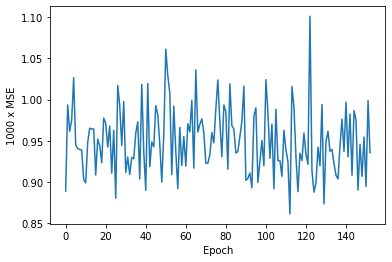

In [86]:
def loss_hist_by_epoch(loss_10_batch):
    # Convert the loss every 10 batches to the average loss per epoch (340 batches)
    pnts_per_epoch = 34
    n_pnt = loss_10_batch.shape[0]
    
    loss_per_epoch = []
    i_start = 0
    while i_start < n_pnt-1:
        i_end = i_start + pnts_per_epoch
        loss_per_epoch.append(loss_10_batch[i_start:i_end].mean())
        i_start = i_end
        
    return loss_per_epoch
    
plt.plot(loss_hist_by_epoch(loss_hist))
plt.xlabel('Epoch')
plt.ylabel('1000 x MSE')

## 5. Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [35]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


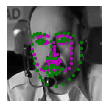

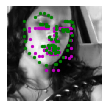

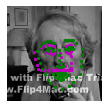

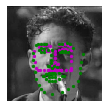

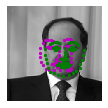

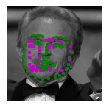

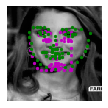

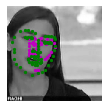

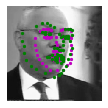

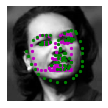

In [36]:
## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:

visualize_output(test_images, test_outputs, gt_pts)

Once you've found a good model (or two), save your model so you can load it and use it later!

In [37]:
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'keypoints_model_1.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


**Answer**: write your answer here (double click to edit this cell)

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**: write your answer here

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**: write your answer here

## 6. Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

[[-0.0718361  -0.17920657  0.04929365 -0.17433569 -0.23014824]
 [-0.14013474 -0.12059972 -0.16218291  0.13771068  0.07201082]
 [-0.1420003   0.12161724  0.13717455  0.14431317 -0.1250145 ]
 [-0.06744753  0.18146499 -0.11747703 -0.10968588 -0.11100615]
 [-0.0254928  -0.20466557 -0.10391778 -0.13002993  0.01313291]]
(5, 5)


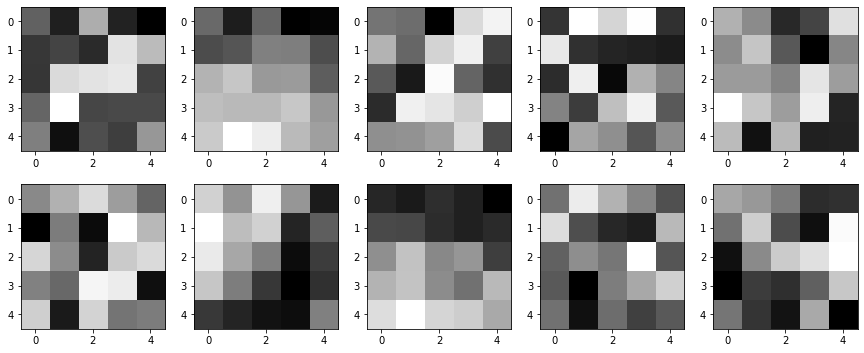

In [89]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data

w = weights1.numpy()


filter_index = 0
print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(w[i][0], cmap='gray')


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

(1, 224, 224)
The min value: 0.015686275
The max value: 0.9843137


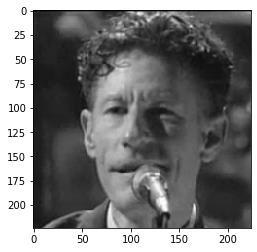

In [56]:
##TODO: load in and display any image from the transformed test dataset
img_index = 3
# img_sample = test_images[img_index][0]
# print(img_sample.shape)
# print(type(img_sample))

image = test_images[img_index].data   # get the image from it's wrapper
image = image.numpy()   # convert to numpy array from a Tensor

print(image.shape)
print("The min value:", np.amin(image))
print("The max value:", np.amax(image))
plt.imshow(image[0], cmap='gray')


## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image

In [92]:
import cv2

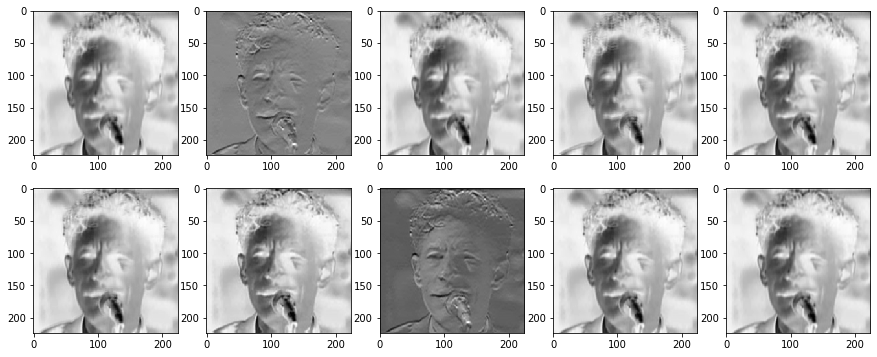

In [94]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
for ind, ax in enumerate(axes.flat):
    filtered = cv2.filter2D(src=image, ddepth=-1, kernel=w[ind][0])
    ax.imshow(filtered[0], cmap='gray')

In [74]:
w.shape

(32, 1, 5, 5)

### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**: (does it detect vertical lines or does it blur out noise, etc.) write your answer here

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!